# Transform Data

### Imports

In [1]:
########################################################################
# Required for Jupyter Notebooks to find the src directory.
import sys
sys.path.append('../')
########################################################################

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau

from src.data_loading.loaders import DataRetriever
from src.data_transformation.transformer import DataTransformer

## Load Data from Data Directory

Read the real GDP data from the data directory.

In [2]:
excel_loader = DataRetriever.create(
    path_or_url='../data/real_gdp.xlsx'
)

real_gdp = excel_loader.load_data()

print(real_gdp.shape)
real_gdp.head()

(312, 4)


,realtime_start,realtime_end,date,value
0,2025-03-06,2025-03-06,1947-01-01,2182.681
1,2025-03-06,2025-03-06,1947-04-01,2176.892
2,2025-03-06,2025-03-06,1947-07-01,2172.432
3,2025-03-06,2025-03-06,1947-10-01,2206.452
4,2025-03-06,2025-03-06,1948-01-01,2239.682


Read the government production data from the data directory.

In [3]:
excel_loader = DataRetriever.create(
    path_or_url='../data/gov_prod.xlsx'
)

gov_prod = excel_loader.load_data()

print(gov_prod.shape)
gov_prod.head()

(312, 4)


,realtime_start,realtime_end,date,value
0,2025-03-06,2025-03-06,1947-01-01,560.515
1,2025-03-06,2025-03-06,1947-04-01,560.091
2,2025-03-06,2025-03-06,1947-07-01,560.034
3,2025-03-06,2025-03-06,1947-10-01,555.556
4,2025-03-06,2025-03-06,1948-01-01,563.895


## Combine Datasets

Merge the two dataframes on the date column.

In [4]:
real_gdp = (
    real_gdp
    .drop(columns=['realtime_start', 'realtime_end'])
    .rename(columns={'value': 'real_gdp'})
)

In [5]:
gov_prod = (
    gov_prod
    .drop(columns=['realtime_start', 'realtime_end'])
    .rename(columns={'value': 'gov_prod'})
)

In [6]:
data = real_gdp.merge(gov_prod, on='date', how='left', indicator=True)

print(data.shape)
print(data['_merge'].value_counts())
data.head()

(312, 4)
_merge
both          312
left_only       0
right_only      0
Name: count, dtype: int64


,date,real_gdp,gov_prod,_merge
0,1947-01-01,2182.681,560.515,both
1,1947-04-01,2176.892,560.091,both
2,1947-07-01,2172.432,560.034,both
3,1947-10-01,2206.452,555.556,both
4,1948-01-01,2239.682,563.895,both


Calculate private GDP.

In [7]:
data['real_gdpp'] = data['real_gdp'] - data['gov_prod']

## Transform the Series

In [8]:
transformer = DataTransformer(dataframe=data)

Log transform the data.

In [9]:
transformer.log_transform(column='real_gdp', new_col_name='real_gdp_log')
transformer.log_transform(column='real_gdpp', new_col_name='real_gdpp_log')

transformer.dataframe.head()

,date,real_gdp,gov_prod,_merge,real_gdpp,real_gdp_log,real_gdpp_log
0,1947-01-01,2182.681,560.515,both,1622.166,7.688309,7.391518
1,1947-04-01,2176.892,560.091,both,1616.801,7.685653,7.388205
2,1947-07-01,2172.432,560.034,both,1612.398,7.683603,7.385478
3,1947-10-01,2206.452,555.556,both,1650.896,7.699141,7.409073
4,1948-01-01,2239.682,563.895,both,1675.787,7.714089,7.424038


Log difference the data.

In [10]:
transformer.difference(column='real_gdp_log', date_column='date', new_col_name='real_gdp_log_diff')
transformer.difference(column='real_gdpp_log', date_column='date', new_col_name='real_gdpp_log_diff')

transformer.dataframe.head()

,date,real_gdp,gov_prod,_merge,real_gdpp,real_gdp_log,real_gdpp_log,real_gdp_log_diff,real_gdpp_log_diff
0,1947-01-01,2182.681,560.515,both,1622.166,7.688309,7.391518,NaN,NaN
1,1947-04-01,2176.892,560.091,both,1616.801,7.685653,7.388205,-0.002656,-0.003313
2,1947-07-01,2172.432,560.034,both,1612.398,7.683603,7.385478,-0.002051,-0.002727
3,1947-10-01,2206.452,555.556,both,1650.896,7.699141,7.409073,0.015539,0.023596
4,1948-01-01,2239.682,563.895,both,1675.787,7.714089,7.424038,0.014948,0.014965


## Apply Filters

In [11]:
cols = [
    'real_gdp', 'real_gdpp', 'real_gdp_log', 'real_gdpp_log'
]

In [12]:
for col in cols:

    print(col)

    # Apply the HP filter.
    transformer.hp_filter(
        column=col, lamb=1600, cycle_col_name=f'{col}_hp_cycle',
        trend_col_name=f'{col}_hp_trend'
    )

    # Apply the BK filter.
    transformer.bk_filter(
        column=col, cycle_col_name=f'{col}_bk_cycle',
        trend_col_name=f'{col}_bk_trend'
    )

    # Linear detrend the data.
    transformer.linear_detrend(
        column=col, new_col_name=f'{col}_lin_cycle',
        trend_col_name=f'{col}_lin_trend'
    )

real_gdp
real_gdpp
real_gdp_log
real_gdpp_log


Write to file.

In [13]:
# Write the data to an Excel file.
transformer.dataframe.to_excel('../data/transformed_data.xlsx', index=False)

## Figures

Figure 1

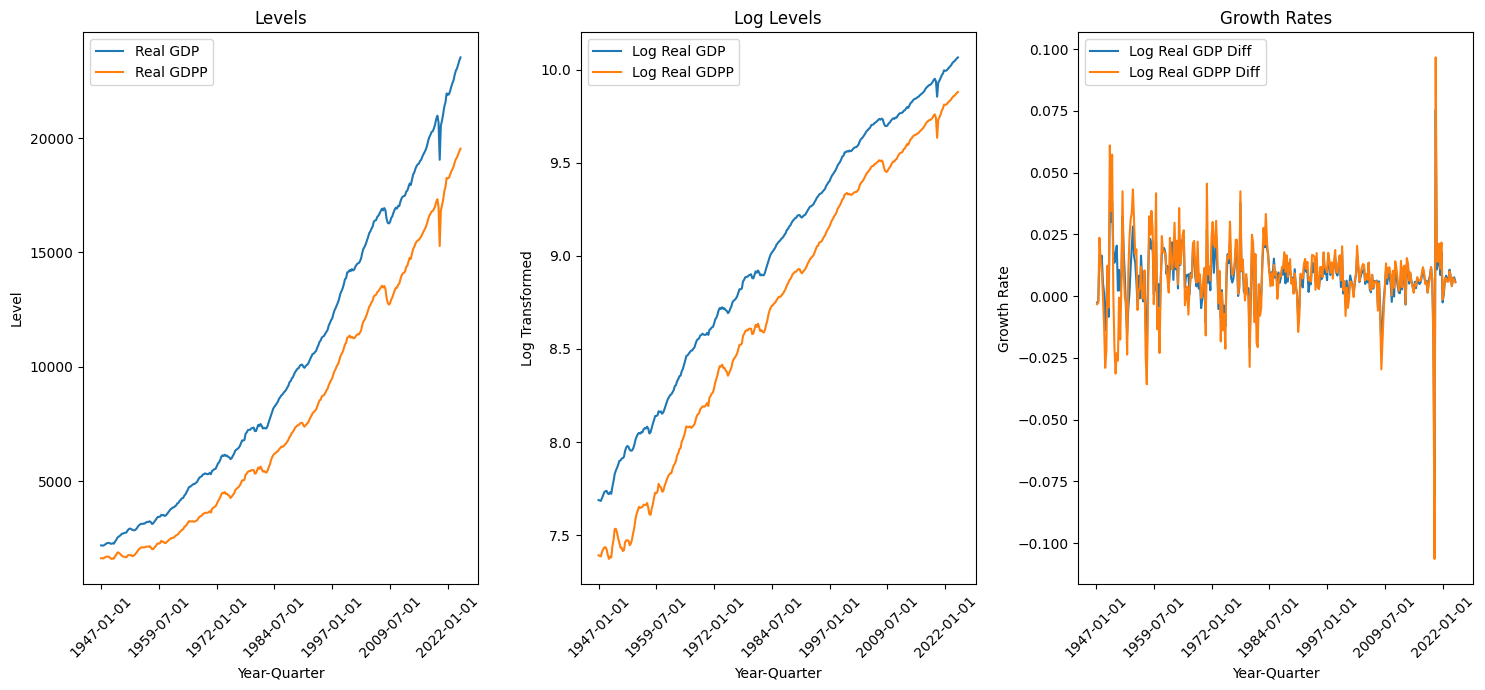

In [14]:
# Pairs of series to plot.
pairs = [
    ('real_gdp', 'real_gdpp', 'Real GDP', 'Real GDPP', 'Levels', 'Year-Quarter', 'Level'),
    ('real_gdp_log', 'real_gdpp_log', 'Log Real GDP', 'Log Real GDPP', 'Log Levels', 'Year-Quarter', 'Log Transformed'),
    ('real_gdp_log_diff', 'real_gdpp_log_diff', 'Log Real GDP Diff', 'Log Real GDPP Diff', 'Growth Rates', 'Year-Quarter', 'Growth Rate')
]

# Create a figure with two subplots.
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7), sharex=True)

# Flatten the axes and zip with the pairs of series and labels.
ax = ax.flatten()
ax_pairs = zip(ax, pairs)

for a, (left, right, left_label, right_label, title, xlabel, ylabel) in ax_pairs:

    # Plot the series.
    a.plot('date', left, data=transformer.dataframe, label=left_label)
    a.plot('date', right, data=transformer.dataframe, label=right_label)
    a.legend()

    a.set_title(title)
    a.set_xlabel(xlabel)
    a.set_ylabel(ylabel)
    a.tick_params(axis='x', rotation=45)

# Set the x-axis ticks.
ax[0].set_xticks(range(0, len(transformer.dataframe), 50))

# Show the plot.
plt.tight_layout()
# plt.show()
plt.savefig('../docs/figures/figure_1.png')

Figure 2

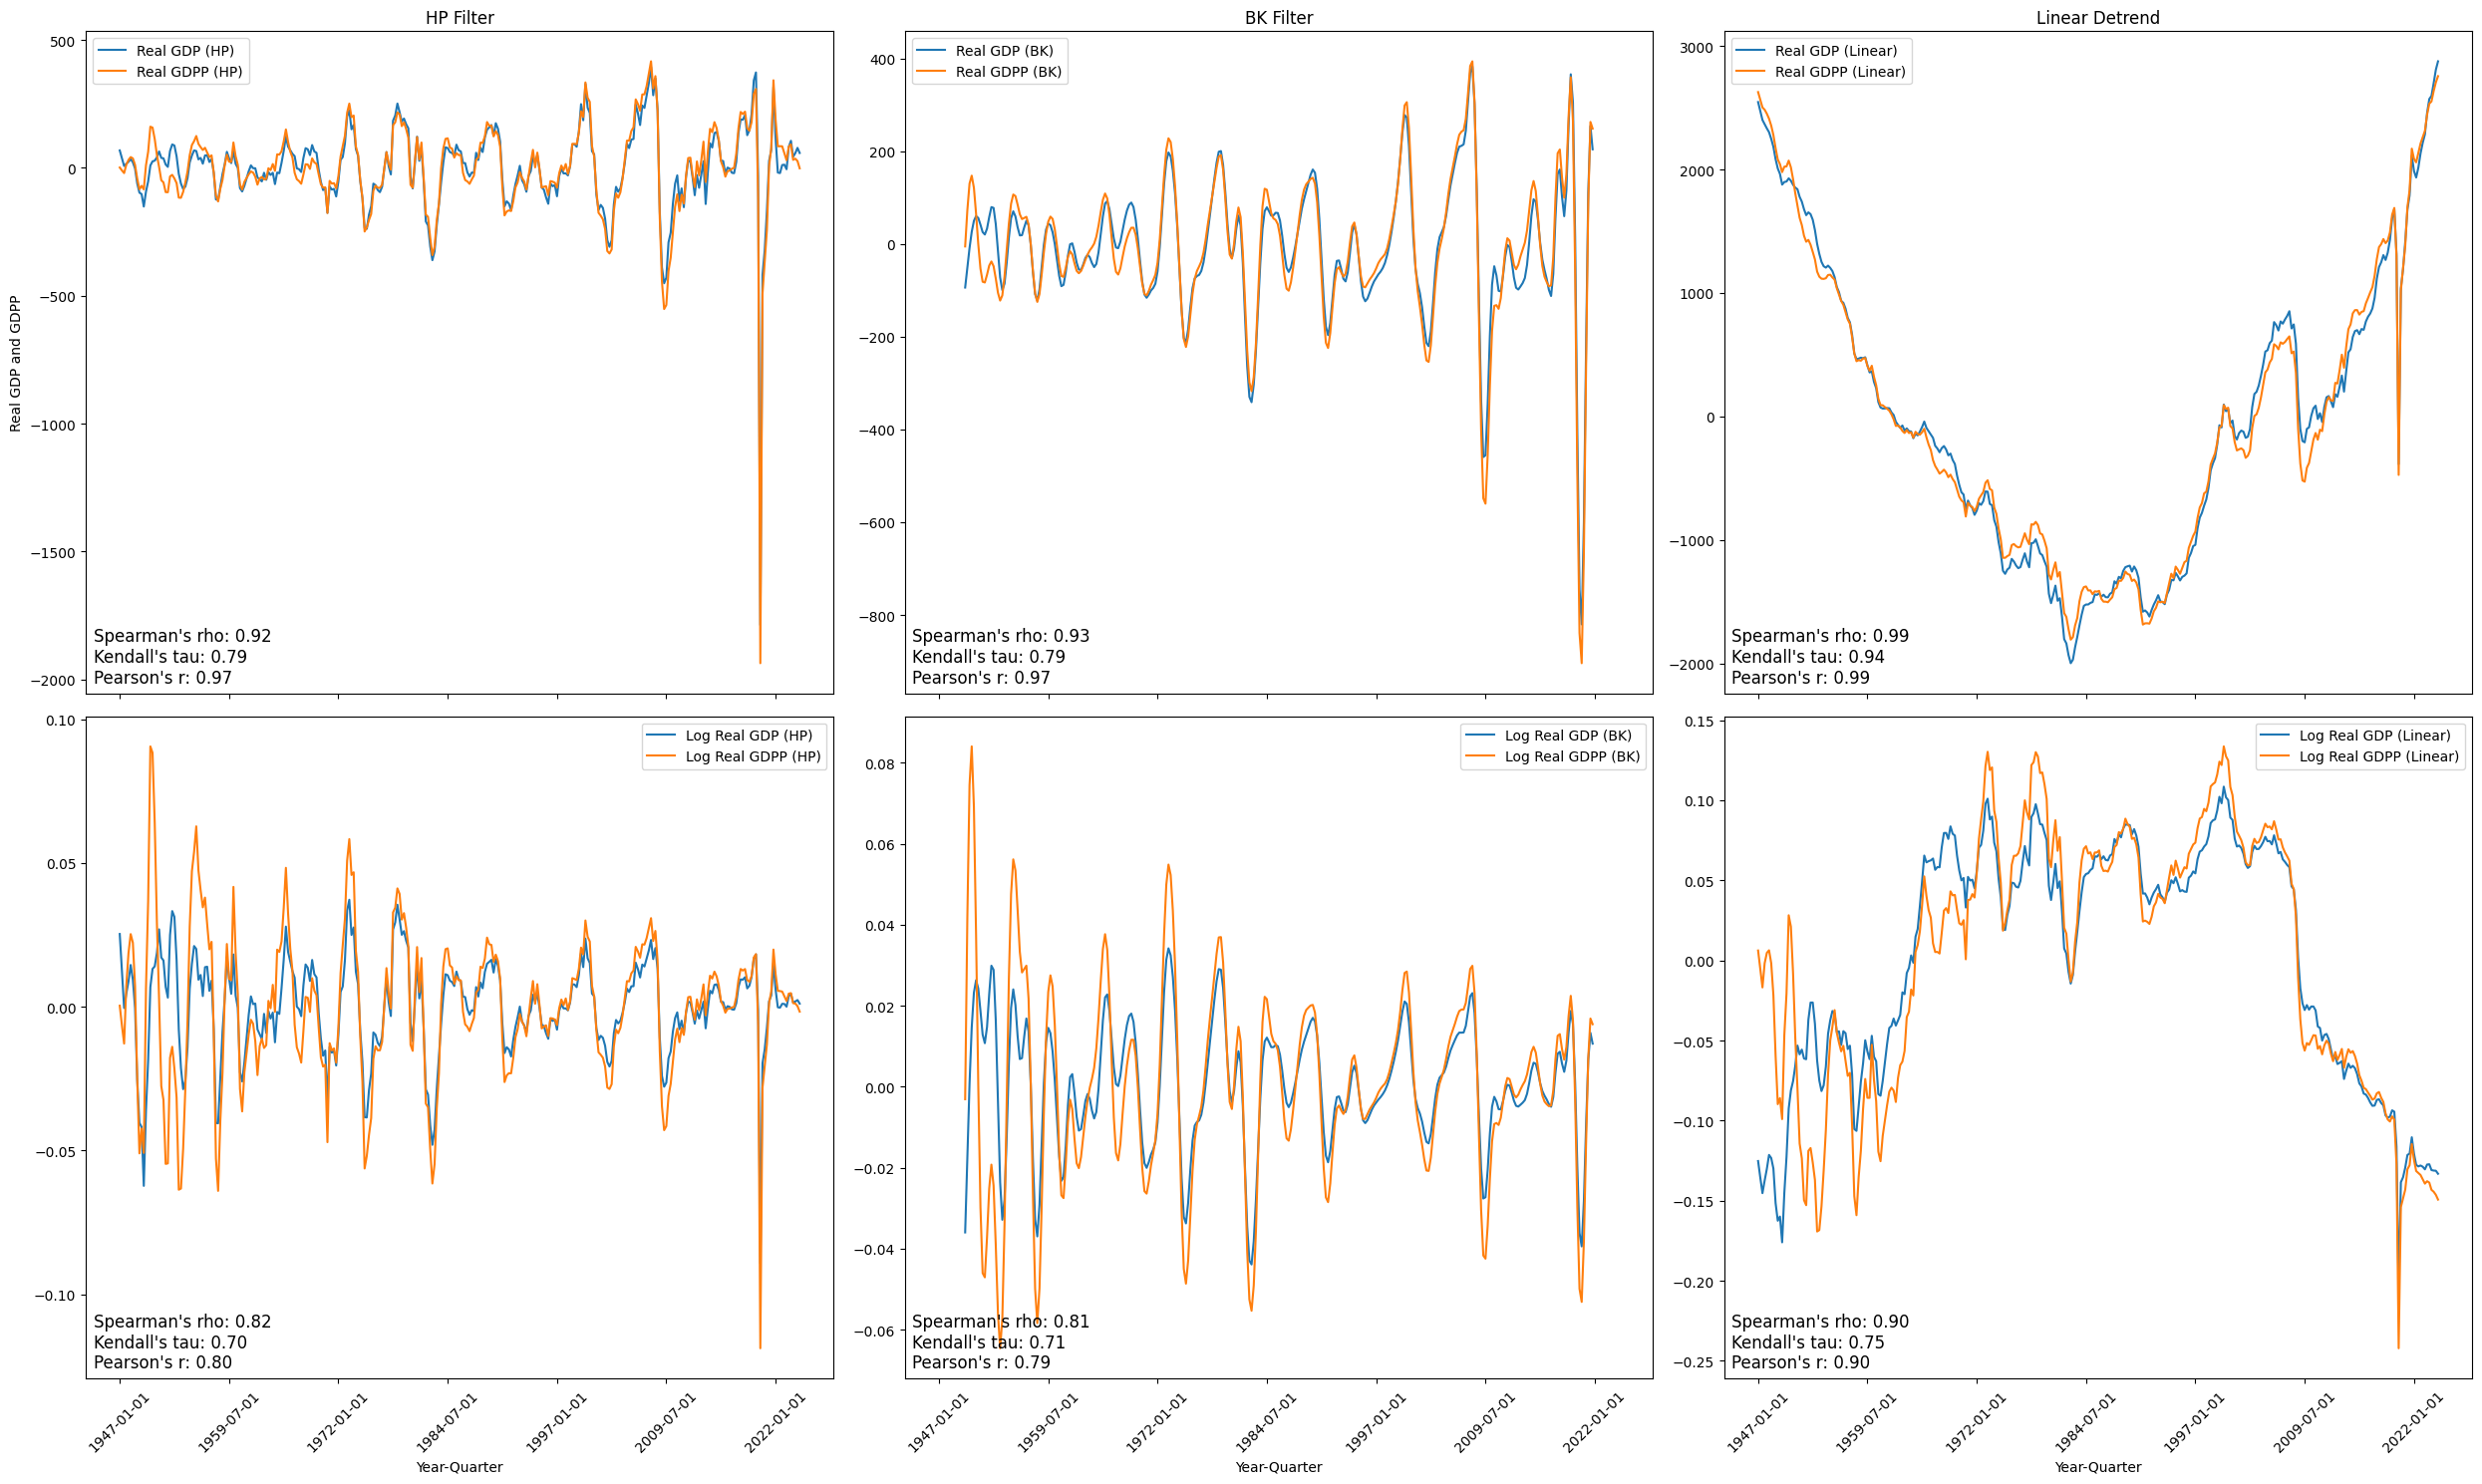

In [15]:
# Pairs of series to plot.
pairs = [
    ('real_gdp_hp_cycle', 'real_gdpp_hp_cycle', 'Real GDP (HP)', 'Real GDPP (HP)'),
    ('real_gdp_bk_cycle', 'real_gdpp_bk_cycle', 'Real GDP (BK)', 'Real GDPP (BK)'),
    ('real_gdp_lin_cycle', 'real_gdpp_lin_cycle', 'Real GDP (Linear)', 'Real GDPP (Linear)'),
    ('real_gdp_log_hp_cycle', 'real_gdpp_log_hp_cycle', 'Log Real GDP (HP)', 'Log Real GDPP (HP)'),
    ('real_gdp_log_bk_cycle', 'real_gdpp_log_bk_cycle', 'Log Real GDP (BK)', 'Log Real GDPP (BK)'),
    ('real_gdp_log_lin_cycle', 'real_gdpp_log_lin_cycle', 'Log Real GDP (Linear)', 'Log Real GDPP (Linear)')
]

# Create a figure with two subplots.
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 15), sharex=True)

# Flatten the axes and zip with the pairs of series and labels.
ax = ax.flatten()
ax_pairs = zip(ax, pairs)

for a, (left, right, left_label, right_label) in ax_pairs:

    # Plot the series.
    a.plot('date', left, data=transformer.dataframe, label=left_label)
    a.plot('date', right, data=transformer.dataframe, label=right_label)
    a.legend()

    # Calculate the correlation.
    spearman_rho = spearmanr(data[left].dropna(), data[right].dropna())[0]
    kendall_tau = kendalltau(data[left].dropna(), data[right].dropna())[0]
    pearson_r = pearsonr(data[left].dropna(), data[right].dropna())[0]

    # Add the correlation to the plot.
    corr = (
        f"Spearman's rho: {spearman_rho:.2f}\n"
        f"Kendall's tau: {kendall_tau:.2f}\n"
        f"Pearson's r: {pearson_r:.2f}"
    )

    a.text(
        x=0.01, y=0.01, s=corr, 
        transform=a.transAxes, 
        fontsize=12,
        verticalalignment='bottom', 
        horizontalalignment='left'
    )

# Set the titles and labels for the subplots.
ax[0].set_title('HP Filter')
ax[1].set_title('BK Filter')
ax[2].set_title('Linear Detrend')

ax[0].set_ylabel('Real GDP and GDPP')
ax[3].set_xlabel('Year-Quarter')
ax[4].set_xlabel('Year-Quarter')
ax[5].set_xlabel('Year-Quarter')

# Set the x-axis ticks.
ax[3].set_xticks(range(0, len(transformer.dataframe), 50))
ax[3].tick_params(axis='x', rotation=45)
ax[4].tick_params(axis='x', rotation=45)
ax[5].tick_params(axis='x', rotation=45)

# Show the plot.
plt.tight_layout()
# plt.show()
plt.savefig('../docs/figures/figure_2.png')